<a href="https://colab.research.google.com/github/PlaZMaD/ml_miem_2024/blob/main/Seminar_5_1_Decision_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Семинар 5.1 Деревья решений

(использованы материалы курса [Машинное обучение в Питоне](https://www.hse.ru/edu/courses/450323352))

## Построим собственное дерево решений
(По мотивам примера [Josh Gordon](https://github.com/random-forests/tutorials/blob/master/decision_tree.ipynb))

Построим дерево, которое будет предсказывать домашнее животное по его размерам и цвету.

In [ ]:
# Только Numpy и Pandas
import numpy as np, pandas as pd

Создадим несколько записей:


In [ ]:
pets_data = [
  ['grey', 28, 'cat'],
  ['cream', 25, 'cat'],
  ['brown', 60, 'dog'],
  ['grey', 28, 'dog'],
  ['green', 17, 'parrot'],
  ['green', 12, 'turtle'],
]

columns = ['color', 'size (cm)', 'label']
pets = pd.DataFrame(pets_data, columns = columns)

Заметили, что кошка из первой записи и собака из четвёртой имеют идентичные признаки? Как дерево справится с этим?

In [ ]:
pets

Выбирем уникальные значения как для числовых, так и для категориальных признаков:

In [ ]:
def unique_vals(rows, col):
  return set([row[col] for row in rows])

In [ ]:
unique_vals(pets_data, 1)

In [ ]:
unique_vals(pets_data, 0)

Функция подсчитывает количество экземпляров каждого класса в наборе данных:

In [ ]:
def class_counts(rows):
    counts = {}
    for row in rows:
        label = row[-1]
        if label not in counts:
            counts[label] = 0
        counts[label] += 1
    return counts

Научим модель задавать некоторые вопросы.

Эта простая функция может это сделать:

In [ ]:
def question(col, val):
  if not np.char.isnumeric(str(val)):
    condition = " == "
  else:
    condition = " >= "
  print("Is " + pets.columns[col] + condition + str(val) + "?")

In [ ]:
question(1, 30)

In [ ]:
question(0, 'green')

В целях автоматизации, давайте создадим класс, который сможет обрабатывать вопросы.

In [ ]:
def is_numeric(value):
    """Test if a value is numeric."""
    return isinstance(value, int) or isinstance(value, float)

In [ ]:
class Question:

    def __init__(self, column, value):
        self.column = column
        self.value = value

    def match(self, example):
        # Compare the feature value in an example to the
        # feature value in this question.
        val = example[self.column]
        if is_numeric(val):
            return val >= self.value
        else:
            return val == self.value

    def __repr__(self):
        # This is just a helper method to print
        # the question in a readable format.
        condition = "=="
        if is_numeric(self.value):
            condition = ">="
        return "Is %s %s %s?" % (
            columns[self.column], condition, str(self.value))

In [ ]:
Question(1, 30)

In [ ]:
Question(0, 'green')

Мы также можем сопоставить вопрос с конкретной записью:

In [ ]:
q = Question(0, 'cream')

In [ ]:
q.match(pets_data[0])

In [ ]:
q.match(pets_data[1])

Правильно. Кремовый" цвет находится в записи с индексом 1:


In [ ]:
pets

Нам также нужно подсчитать, сколько у нас меток классов:

In [ ]:
print(pets.label.value_counts())

Давайте определим разбиение. Задав вопрос (см. выше), мы можем разделить набор данных на *true_records* (в случае положительного ответа) и *false_records* (для отрицательного ответа). Отнесем к положительному ответу тот случай, когда числовое значение равно или больше значения в вопросе, и наоборот.

In [ ]:
def partition(rows, question):
    """Partitions a dataset.

    For each row in the dataset, check if it matches the question. If
    so, add it to 'true rows', otherwise, add it to 'false rows'.
    """
    true_records, false_records = [], []
    for row in rows:
        if question.match(row):
            true_records.append(row)
        else:
            false_records.append(row)
    return true_records, false_records

Теперь мы можем легко выбрать записи, помеченные как "собака":

In [ ]:
# true_records, false_records = partition(pets_data, Question(2, 'dog'))
# true_records, false_records = partition(pets_data, Question(1, 27))
true_records, false_records = partition(pets_data, Question(0, 'green'))

true_records

... или записи, наоборот, несвязанные с собаками:

In [ ]:
false_records

При построении дерева классификации для оценки качества конкретного разбиения обычно используется индекс Джини (а также энтропия и другие меры). Коэффициент Джини примеси для $i$ подмножества:

$$G_i = \sum_{k=1}^K \hat{p}_{i,k}(1 - \hat{p}_{i,k}) = \sum_{k=1}^K \hat{p}_{i,k} - \sum_{k=1}^K \hat{p}_{i,k}^2 = 1 - \sum_{k=1}^K \hat{p}_{i,k}^2$$

In [ ]:
def gini(rows):
    counts = class_counts(rows)
    impurity = 1
    for lbl in counts:
        prob_of_lbl = counts[lbl] / float(len(rows))
        impurity -= prob_of_lbl**2
    return impurity

Давайте рассмотрим несколько примеров, чтобы понять, как работает Gini Impurity. Сначала мы рассмотрим набор данных без смешивания:

In [ ]:
no_mixing = [['cat'],
              ['cat']]

gini(no_mixing)

Теперь мы рассмотрим набор данных с соотношением кошек и собак 50/50:

In [ ]:
some_mixing = [['cat'],['dog']]
gini(some_mixing)

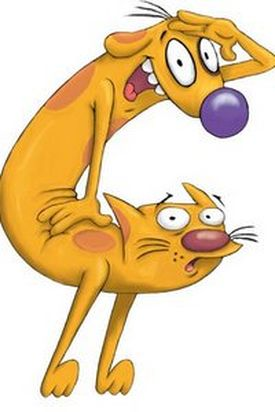

CatDog TV series created by Peter Hannan for Nickelodeon (unknown artist, [image source](https://www.pinterest.com/pin/495325659015162222/))

Теперь мы рассмотрим набор данных с множеством различных меток:

In [ ]:
lots_of_mixing = [['cat'],
                  ['cat'],
                  ['hamster'],
                  ['guinea pig'],
                  ['chameleon']]

gini(lots_of_mixing)

Определим информационный прирост как неопределенность в начальном узле минус взвешенная примесь в двух дочерних узлах:

In [ ]:
def info_gain(left, right, current_uncertainty):
    p = float(len(left)) / (len(left) + len(right))
    return current_uncertainty - p * gini(left) - (1 - p) * gini(right)

Посчитаем неопределенность на тренировочной выборке.

In [ ]:
pets_data

In [ ]:
current_uncertainty = gini(pets_data)
current_uncertainty

Сколько информации мы получим при разбиении по `size = 15`?

In [ ]:
true_records, false_records = partition(pets_data, Question(1, 15))
info_gain(true_records, false_records, current_uncertainty)

... `size = 25`?

In [ ]:
true_records, false_records = partition(pets_data, Question(1, 25))
info_gain(true_records, false_records, current_uncertainty)

... `size = 30`?

In [ ]:
true_records, false_records = partition(pets_data, Question(1, 30))
info_gain(true_records, false_records, current_uncertainty)

In [ ]:
pets_data

# Упражнение:
Почему мы получили больше информации при разбиении с использованием `size = 30`?

Посмотрите на различные полученные в результате разбиения результаты и определите, какой из них кажется вам более "несмешанным".

Давайте найдем лучший вопрос, который можно задать, перебирая все характеристики и значения и вычисляя прирост информации.

In [ ]:
def find_best_split(rows):
    """Find the best question to ask by iterating over every feature / value
    and calculating the information gain."""
    best_gain = 0  # keep track of the best information gain
    best_question = None  # keep train of the feature / value that produced it
    current_uncertainty = gini(rows)
    n_features = len(rows[0]) - 1  # number of columns

    for col in range(n_features):  # for each feature

        values = set([row[col] for row in rows])  # unique values in the column

        for val in values:  # for each value

            question = Question(col, val)

            # try splitting the dataset
            true_rows, false_rows = partition(rows, question)

            # Skip this split if it doesn't divide the
            # dataset.
            if len(true_rows) == 0 or len(false_rows) == 0:
                continue

            # Calculate the information gain from this split
            gain = info_gain(true_rows, false_rows, current_uncertainty)

            # You actually can use '>' instead of '>=' here
            # but I wanted the tree to look a certain way for our
            # toy dataset.
            if gain >= best_gain:
                best_gain, best_question = gain, question

    return best_gain, best_question

Найдите лучший вопрос, который следует задать первым для нашего набора данных.


In [ ]:
best_gain, best_question = find_best_split(pets_data)
best_question

Бинго!

Алгоритм подтвердил, что разбиение с использованием size = 25 является наилучшим.

Давайте напишем еще несколько классов и функций для более удобной работы с деревом:

In [ ]:
class Leaf:

    def __init__(self, rows):
      self.predictions = class_counts(rows)

In [ ]:
class Decision_Node:

    def __init__(self,
                 question,
                 true_branch,
                 false_branch):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch

Эта функция разбивает набор данных по каждому уникальному признаку, вычисляет прирост информации и возвращает узел вопроса (лучший признак/значение для вопроса).

In [ ]:
def build_tree(rows):
    gain, question = find_best_split(rows)
    if gain == 0: return Leaf(rows)
    true_rows, false_rows = partition(rows, question)

    true_branch = build_tree(true_rows)
    false_branch = build_tree(false_rows)
    return Decision_Node(question, true_branch, false_branch)

Эта функция помогает получить человекочитаемые результаты (как для вопросов, так и для предсказаний).

In [ ]:
def print_tree(node, spacing=""):
    """World's most elegant tree printing function."""

    # Base case: we've reached a leaf
    if isinstance(node, Leaf):
        print (spacing + "Predict", node.predictions)
        return

    # Print the question at this node
    print (spacing + str(node.question))

    # Call this function recursively on the true branch
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Call this function recursively on the false branch
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [ ]:
my_tree = build_tree(pets_data)

In [ ]:
print_tree(my_tree)

In [ ]:
def classify(row, node):
    """See the 'rules of recursion' above."""

    # Base case: we've reached a leaf
    if isinstance(node, Leaf):
        return node.predictions

    # Decide whether to follow the true-branch or the false-branch.
    # Compare the feature / value stored in the node,
    # to the example we're considering.
    if node.question.match(row):
        return classify(row, node.true_branch)
    else:
        return classify(row, node.false_branch)

In [ ]:
#######
# Demo:
# The tree predicts the 2nd row of our
# training data is an apple with confidence 1.
classify(pets_data[0], my_tree)
#######

In [ ]:
def print_leaf(counts):
    """A nicer way to print the predictions at a leaf."""
    total = sum(counts.values()) * 1.0
    probs = {}
    for lbl in counts.keys():
        probs[lbl] = str(int(counts[lbl] / total * 100)) + "%"
    return probs

In [ ]:
#######
# Demo:
# Printing that a bit nicer
print_leaf(classify(pets_data[3], my_tree))
#######

In [ ]:
#######
# Demo:
# On the second example, the confidence is lower
print_leaf(classify(pets_data[4], my_tree))
#######

Давайте попробуем применить дерево на следующем наборе данных:

In [ ]:
# Evaluate on
domestic_animals = [
  ['brown', 35, 'cat'],
  ['grey', 20, 'cat'],
  ['cream', 26, 'cat'],
  ['grey', 70, 'dog'],
  ['white', 50, 'parrot'],
  ['albino', 10, 'turtle'],
]

In [ ]:
pets_data

In [ ]:
for row in domestic_animals:
    print ("Actual: %s. Predicted: %s" %
           (row[-1], print_leaf(classify(row, my_tree))))

Результаты классификации не блестящие. Почему?

# Упражнение
Попробуйте добавить больше признаков и примеров к "домашним животным" и оцените дерево на расширенном наборе данных "domestic_animals".

In [ ]:
header = ['color', 'size', 'extra feature', 'label']

pets = [
  ['grey', 28, '...', 'cat'],
  ['cream', 25, '...', 'cat'],
  ['brown', 60, '...', 'dog'],
  ['grey', 28, '...', 'dog'],
  ['green', 17, '...', 'parrot'],
  ['green', 12, '...', 'turtle'],
]

domestic_animals = [
  ['grey', 28, '...', 'cat'],
  ['cream', 25, '...', 'cat'],
  ['brown', 60, '...', 'dog'],
  ['grey', 28, '...', 'dog'],
  ['green', 17, '...', 'parrot'],
  ['green', 12, '...', 'turtle'],
]

In [ ]:
my_tree = build_tree(pets)

In [ ]:
print_tree(my_tree)

In [ ]:
for row in domestic_animals:
    print ("Actual: %s. Predicted: %s" %
           (row[-1], print_leaf(classify(row, my_tree))))

# Classification And Regression (decision) Trees (CART)
В этой части семинара мы рассмотрим набор данных [*Hitters.csv*](https://rdrr.io/cran/ISLR/man/Hitters.html) и построим модель [дерева решений (DT) из Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor) для **прогнозирования зарплат** бейсболистов. Датафрейм с 322 наблюдениями игроков высшей лиги (по одной строке на игрока) по следующим 20 переменным.


1. AtBat: # of times at bat in 1986
1. Hits: # of hits in 1986
1. HmRun: # of home runs in 1986
1. Runs: # of runs in 1986
1. RBI: # of runs batted in in 1986
1. Walks: # of walks in 1986
1. Years: # of years in the major leagues
1. CAtBat: # of times at bat during his career
1. CHits: # of hits during his career
1. CHmRun: # of home runs during his career
1. CRuns: # of runs during his career
1. CRBI: # of runs batted in during his career
1. CWalks: # of walks during his career
1. League: a factor with levels `A` and `N` indicating player's league at the end of 1986
1. Division: a factor with levels `E` and `W` indicating player's division at the end of 1986
1. PutOuts: # of put outs in 1986
1. Assists: # of assists in 1986
1. Errors: # of errors in 1986
1. Salary: 1987 annual salary on opening day in thousands of dollars
1. NewLeague: a factor with levels `A` and `N` indicating player's league at the beginning of 1987

<font color=gray>
    
## Описание датасета

In [ ]:
import pandas as pd, numpy as np, seaborn as sns, sklearn, matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"   # enables multiple outputs from a single cell
pd.set_option('display.max_rows', 6)
plt.rcParams['figure.figsize'] = [18, 4]

df = pd.read_csv('https://github.com/JWarmenhoven/ISLR-python/raw/master/Notebooks/Data/Hitters.csv')
df = df.rename(columns={'Unnamed: 0':'name'})
df  # Evaluate values, units, data types, anything unusual

In [ ]:
df.info()

In [ ]:
pd.set_option('display.max_rows', 100)
dfStats = df.describe().drop('count', axis=0)
dfStats.loc['IQR'] = dfStats.loc['75%'] - dfStats.loc['25%'] # appending interquartile range instead of recalculating it
# dfStats = pd.concat([dfStats, df.reindex(dfStats.columns, axis=1).agg(['skew', 'mad', 'kurt'])])
dfStats.round(2)

In [ ]:
plt.rcParams['figure.figsize'] = [30, 10]
ax = sns.heatmap(df.isnull().T, cmap = "BuPu", cbar=False);
ax.set_title('Missing values (in blue)');

In [ ]:
ax = sns.pairplot(df.loc[~ df.Salary.isna(),], plot_kws=dict(linewidth=0, s=5), height=1.5);
ax.fig.suptitle("Pairplot of variables in Hitters dataset", y=1);
plt.tight_layout();
plt.show();


# Baseline model, v0
Поскольку нам нужно построить модель для предсказания переменной `Salary`, отсутствующие значения в `Salary` не пригодятся ни для обучения, ни для оценки. Давайте пока удалим их. В качестве альтернативы мы можем просто заполнить NA нулями с помощью функции `df.fillna(0)`.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

df = df.loc[~ df.Salary.isna(),]     # keep rows where salary values are not NaN.
X = df._get_numeric_data().drop('Salary', axis=1)
Y = df['Salary']
tX, vX, tY, vY = train_test_split(X, Y, test_size=0.2, random_state=0)

Для регрессионного анализа обычными подходящими метриками являются $R^2=1-SSR/SST$, MSE, RMSE (=$\sqrt{MSE}$). В некотором смысле они [все связаны](https://stats.stackexchange.com/questions/214886/regression-what-is-the-utility-of-r-squared-compared-to-rmse). $R^2$ легче интерпретировать, потому что он нормирован на [0,1] (но может быть отрицательным, если SSR>>SST). Примечание: Для регрессионных моделей не следует *не* использовать метрики классификации, такие как accuracy, precision, recall, $F_1$, и т.д.

In [ ]:
?DecisionTreeRegressor

In [ ]:
from sklearn.metrics import r2_score
v0 = DecisionTreeRegressor(random_state=0)     # decision tree baseline model
v0.fit(tX, tY)

tmp = sklearn.tree.plot_tree(v0);
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
dfT = pd.DataFrame([v0.predict(tX), tY], index=['Pred Salary (train)', 'Actual Salary (train)']).T
dfV = pd.DataFrame([v0.predict(vX), vY], index=['Pred Salary (val)',   'Actual Salary (val)']).T
pd.concat([dfT.head(), dfV.head()], axis=1)
a = dfT.plot.scatter(0,1, grid=True, ax=ax1, title=f'$R^2$: {v0.score(tX, tY)} on train')   # in-sample predictions
a = dfV.plot.scatter(0,1, grid=True, ax=ax2, title=f'$R^2$: {v0.score(vX, vY):0.2f} on test')   # out-of-sample predictions
plt.tight_layout()

Мы видим идеальное соответствие на обучающих данных и плохое соответствие на тестовых данных (R^2 = 44%).

# Настроим гиперпараметры
Мы можем оценить эту модель при различных значениях гиперпараметра `max_depth` и выбрать наилучшее.

In [ ]:
?DecisionTreeRegressor

In [ ]:
m = DecisionTreeRegressor(random_state=0, max_depth=5)     # baseline model
m.fit(tX, tY)
print(f'\nR^2: {m.score(tX, tY):.2f} on train, {m.score(vX, vY):.2f} on test')   # a strong learner will overfit, if not constrained
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
dfT = pd.DataFrame([m.predict(tX), tY], index=['Pred Salary (train)','Actual Salary (train)']).T
dfV = pd.DataFrame([m.predict(vX), vY], index=['Pred Salary (val)','Actual Salary (val)']).T
pd.concat([dfT.head(),dfV.head()], axis=1)
# a = dfT.plot.scatter(0,1, grid=True, ax=ax1)   # Predictions on train set
# a = dfV.plot.scatter(0,1, grid=True, ax=ax2)   #  Predictions on validation set
a = dfT.plot.scatter(0,1, grid=True, ax=ax1, title=f'$R^2$: {m.score(tX, tY)} on train')   # in-sample predictions
a = dfV.plot.scatter(0,1, grid=True, ax=ax2, title=f'$R^2$: {m.score(vX, vY):0.2f} on test')   # out-of-sample predictions

In [ ]:
# plt.rcParams['figure.figsize'] = [30, 10]
tmp = sklearn.tree.plot_tree(m);

In [ ]:
res = []   #result
m = DecisionTreeRegressor(random_state=0)     # baseline model
for i in range(1,20):
    a = m.set_params(max_depth=i).fit(tX, tY)
    res.append((i, m.score(tX, tY), m.score(vX, vY)))
dfRes = pd.DataFrame(res, columns=['depth','train_R2','test_R2']).set_index('depth')
a = dfRes.plot(grid=True, title='train and test Perfomance ($R^2$)')
# ?dt.score

В то время как производительность модели на тренировочной выборке увеличивается с глубиной, производительность на тестовой ухудшается после глубины 10-12. Это также зависит от других факторов, таких как ```random seed```.



Кросс-валидация (CV) позволяет нам повторно использовать все данные для оценки оптимальных значений параметров.

In [ ]:
m = DecisionTreeRegressor(random_state=0, max_depth=3)
cvR2 = pd.DataFrame(cross_val_score(m, X, Y, cv=10), columns=['vR2']).sort_values('vR2')  # default:  scoring=('r2')
a = cvR2.plot(grid=True, title=f'Avg (valdiation) $R^2$ is {float(cvR2.mean()):.2f} from 10-CV', kind='bar')
a = plt.axhline(float(cvR2.mean()), color='r', linestyle='dashed', linewidth=1)

Мы можем визуализировать конкретное дерево.

In [ ]:
from sklearn.tree import export_graphviz
import os, graphviz,pydotplus
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [ ]:
m = DecisionTreeRegressor(random_state=0, min_samples_leaf=10)
m.fit(tX,tY)
# dot_data = export_graphviz(m, filled=True, rounded=True, feature_names=X.columns, out_file=None)
# dot_data.set_size('"5,5!"')
# graphviz.Source(dot_data, ratio="compress")   # need to install graphviz.gitlab.io

dot_data = export_graphviz(m, filled=True, rounded=True, feature_names=X.columns, out_file=None)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
# pydot_graph.set_size('"30,30!"')
pydot_graph.write_png('resized_tree.png')
from IPython.display import Image
Image("resized_tree.png")

In [ ]:
?graphviz.Source

In [ ]:
[0, 1, 2, 3, 4, 5]
# 0 => gini_0
# 2.5 => gini_1
# 5 => gini_3

# gini_0 < gini_1 < gini_3